# Creating Carbon Dioxide Removal (CDR) Forcing

This notebook demonstrates how to create Carbon Dioxide Removal (CDR) forcing for a ROMS-MARBL simulation. CDR forcing involves specifying one or more CDR releases within a single ROMS-MARBL run.

We will walk through the following steps:

- Defining a CDR release  
- Creating CDR forcing from one or more releases  
- Visualizing the CDR forcing  
- Saving CDR forcing to NetCDF and YAML  
- Reconstructing CDR forcing from a YAML file  

## Creating a Release

CDR forcing in `ROMS-Tools` begins with defining a CDR release. Two types are supported:

- `VolumeRelease`: Injects both water and biogeochemical (BGC) tracers at a specific location (e.g., an underwater pipe).

  - Introduces volume flux and tracer concentrations.
  - Designed for field-scale deployments where mixing still needs to occur.
  - Requires concentration of all 32 MARBL BGC tracers, plus temperature and salinity (defaults available).

- `TracerPerturbation`: Perturbs BGC tracer fields without adding water (i.e., no volume flux).

  - Introduces tracer fluxes, but no volume flux.
  - Designed for large-scale applications where mixing has already occurred (e.g., via a pre-run mixing model).
  - Of the 32 MARBL BGC tracers plus temperature and salinity, only the specified tracers are modified; the rest remain unchanged (equivalent to a perturbation of zero).


### Specifying Location and Spread

Both release types require the following parameters to define the release location:

- `lat`: Latitude (in degrees North) 
- `lon`: Longitude (in degrees East)
- `depth`: Depth (in meters)
- `hsc`: Horizontal scale / standard deviation (in meters)
- `vsc`: Vertical scale / standard deviation (in meters)

By default, `hsc` = `vsc` = 0, resulting in a point source (single grid cell). If `hsc` or `vsc` are greater than zero, the release is spread using a Gaussian.

<div class="alert alert-info">

Notes

- A `VolumeRelease` applied over a broad area (`hsc >> 0` or `vsc >> 0`, larger than the grid scale) can destabilize the model due to distributed buoyancy changes. It is best used as a point source (`hsc` = `vsc` = 0).
- `TracerPerturbation` can safely span larger areas—provided temperature and salinity are not perturbed—since it does not affect buoyancy. A common use case is perturbing alkalinity (`ALK`) or dissolved inorganic carbon (`DIC`) with a Gaussian profile (`hsc >> 0`, `vsc >> 0`) to represent a well-mixed plume.
  
</div>

In [1]:
from datetime import datetime

### Defining a `VolumeRelease`

This section covers how to configure and use the `VolumeRelease` class to represent localized injections of water and tracers in a ROMS simulation.

In addition to the location parameters, a `VolumeRelease` has two key fields:  
- `volume_fluxes`  
- `tracer_concentrations`

Both can be specified as either constant or time-varying.

In [2]:
from roms_tools import VolumeRelease

Call `.get_tracer_metadata()` to view the expected units for each tracer concentration.

In [3]:
VolumeRelease.get_tracer_metadata()

{'temp': {'units': 'degrees Celsius', 'long_name': 'potential temperature'},
 'salt': {'units': 'PSU', 'long_name': 'salinity'},
 'PO4': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic phosphate'},
 'NO3': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic nitrate'},
 'SiO3': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic silicate'},
 'NH4': {'units': 'mmol/m^3', 'long_name': 'dissolved ammonia'},
 'Fe': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic iron'},
 'Lig': {'units': 'mmol/m^3', 'long_name': 'iron binding ligand'},
 'O2': {'units': 'mmol/m^3', 'long_name': 'dissolved oxygen'},
 'DIC': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic carbon'},
 'DIC_ALT_CO2': {'units': 'mmol/m^3',
  'long_name': 'dissolved inorganic carbon, alternative CO2'},
 'ALK': {'units': 'meq/m^3', 'long_name': 'alkalinity'},
 'ALK_ALT_CO2': {'units': 'meq/m^3',
  'long_name': 'alkalinity, alternative CO2'},
 'DOC': {'units': 'mmol/m^3', 'long_name': 'dissolved organi

#### Constant volume flux and tracer concentrations

Here we define a point source release close to Iceland with a volume flux and tracer concentrations that remain constant over time:

- Volume flux: 1000 m³/s  
- Temperature: 20°C  
- Salinity: 1 PSU  
- Alkalinity concentration: 2000 meq/m³  

These values will be applied throughout the entire ROMS simulation period.

In [4]:
constant_volume_release_iceland = VolumeRelease(
    name="iceland_release",
    lat=65.0,  # degree N
    lon=-25,  # degree E
    depth=10,  # m
    volume_fluxes=1000,  # m3/s
    tracer_concentrations={
        "temp": 20.0,  # degrees C
        "salt": 1.0,  # psu
        "ALK": 2000.0,  # meq/m3
    },
)

#### Time-varying volume flux and tracer concentrations

To define a time-varying release, specify the `times` parameter with explicit time points corresponding to the volume fluxes and tracer concentrations.

In the example below, both volume flux and alkalinity concentration vary over time, provided as lists matching the length of `times`. Meanwhile, temperature and salinity remain constant throughout the simulation period. 

<div class="alert alert-info">

Note

Intermediate volume flux and tracer concentration values between the specified times are linearly interpolated when the `CDRForcing` object is constructed later.  
</div>

In [5]:
times = [
    datetime(2011, 1, 15, 12, 0),
    datetime(2011, 1, 15, 15, 0),
    datetime(2011, 1, 15, 18, 0),
    datetime(2011, 1, 19, 0, 0),
    datetime(2011, 1, 22, 6, 0),
    datetime(2011, 1, 22, 9, 0),
    datetime(2011, 1, 22, 12, 0),
]  # 7 entries
volume_fluxes = [0, 100, 500, 1000, 500, 100, 0]  # m3/s, 7 entries
tracer_concentrations = {
    "ALK": [
        1900.0,  # meq/m3
        2100.0,  # meq/m3
        2100.0,  # meq/m3
        2100.0,  # meq/m3
        2100.0,  # meq/m3
        2100.0,  # meq/m3
        1900.0,  # meq/m3
    ],  # 7 entries
    "temp": 20.0,  # degrees C
    "salt": 1.0,  # psu
}

In [6]:
volume_release_greenland = VolumeRelease(
    name="greenland_release",
    lat=70.0,  # degree N
    lon=-20.0,  # degree E
    depth=100,  # m
    times=times,
    volume_fluxes=volume_fluxes,
    tracer_concentrations=tracer_concentrations,
)

### Auto-fill vs. Zero-fill

As noted earlier, ROMS requires concentrations for all 32 BGC tracers, plus temperature and salinity, when defining a `VolumeRelease`. If you don’t specify values for all tracers, use the `fill_values` parameter to control how the missing ones are handled:

- `fill_values = "auto"` *(default)*: Fills unspecified tracer concentrations with non-zero default values.
- `fill_values = "zero"`: Sets all unspecified tracer concentrations to zero.

All previous examples used the default (`"auto"`), which you can verify by checking the fill values for tracers other than `temp`, `salt`, and `ALK` below.

In [7]:
volume_release_greenland

VolumeRelease(name='greenland_release', lat=70.0, lon=-20.0, depth=100.0, hsc=0.0, vsc=0.0, times=[datetime.datetime(2011, 1, 15, 12, 0), datetime.datetime(2011, 1, 15, 15, 0), datetime.datetime(2011, 1, 15, 18, 0), datetime.datetime(2011, 1, 19, 0, 0), datetime.datetime(2011, 1, 22, 6, 0), datetime.datetime(2011, 1, 22, 9, 0), datetime.datetime(2011, 1, 22, 12, 0)], release_type=<ReleaseType.volume: 'volume'>, fill_values='auto', volume_fluxes=Flux(name='volume', values=[0.0, 100.0, 500.0, 1000.0, 500.0, 100.0, 0.0]), tracer_concentrations={'ALK': Concentration(name='ALK', values=[1900.0, 2100.0, 2100.0, 2100.0, 2100.0, 2100.0, 1900.0]), 'temp': Concentration(name='temp', values=20.0), 'salt': Concentration(name='salt', values=1.0), 'PO4': Concentration(name='PO4', values=2.7), 'NO3': Concentration(name='NO3', values=24.2), 'SiO3': Concentration(name='SiO3', values=13.2), 'NH4': Concentration(name='NH4', values=2.2), 'Fe': Concentration(name='Fe', values=1.79), 'Lig': Concentration(na

For example, the default values for `DIC` and `PO4` are 2370.0 mmol/m³ and 2.7 mmol/m³, respectively, as can be seen above.

Next, let's create another release, but this time with `fill_values = "zero"` to explicitly set all unspecified tracer concentrations to zero.

In [8]:
volume_release_norway_with_zero_fill = VolumeRelease(
    name="norway_release_zero_fill",
    lat=65.0,  # degree N
    lon=10,  # degree E
    depth=50,  # m
    times=times,
    volume_fluxes=volume_fluxes,
    tracer_concentrations=tracer_concentrations,
    fill_values="zero",
)

Below, you can see that missing tracer concentrations were correctly set to zero.

In [9]:
volume_release_norway_with_zero_fill

VolumeRelease(name='norway_release_zero_fill', lat=65.0, lon=10.0, depth=50.0, hsc=0.0, vsc=0.0, times=[datetime.datetime(2011, 1, 15, 12, 0), datetime.datetime(2011, 1, 15, 15, 0), datetime.datetime(2011, 1, 15, 18, 0), datetime.datetime(2011, 1, 19, 0, 0), datetime.datetime(2011, 1, 22, 6, 0), datetime.datetime(2011, 1, 22, 9, 0), datetime.datetime(2011, 1, 22, 12, 0)], release_type=<ReleaseType.volume: 'volume'>, fill_values='zero', volume_fluxes=Flux(name='volume', values=[0.0, 100.0, 500.0, 1000.0, 500.0, 100.0, 0.0]), tracer_concentrations={'ALK': Concentration(name='ALK', values=[1900.0, 2100.0, 2100.0, 2100.0, 2100.0, 2100.0, 1900.0]), 'temp': Concentration(name='temp', values=20.0), 'salt': Concentration(name='salt', values=1.0), 'PO4': Concentration(name='PO4', values=0.0), 'NO3': Concentration(name='NO3', values=0.0), 'SiO3': Concentration(name='SiO3', values=0.0), 'NH4': Concentration(name='NH4', values=0.0), 'Fe': Concentration(name='Fe', values=0.0), 'Lig': Concentration(

Note: Later, we’ll cover how to visualize release locations, volume fluxes, and tracer concentrations (including default fill values), once a `CDRForcing` object has been created.

### Defining a `TracerPerturbation`

This section covers how to configure and use the `TracerPerturbation` class to represent injections of tracers without water into a ROMS simulation.

In addition to the location parameters, a `TracerPerturbation` has the key field:  
- `tracer_fluxes`

Both can be specified as either constant or time-varying.

In [10]:
from roms_tools import TracerPerturbation

Call `.get_tracer_metadata()` to view the expected units for each tracer flux.

In [11]:
TracerPerturbation.get_tracer_metadata()

{'temp': {'units': 'degrees Celsius/s', 'long_name': 'potential temperature'},
 'salt': {'units': 'PSU/s', 'long_name': 'salinity'},
 'PO4': {'units': 'mmol/s', 'long_name': 'dissolved inorganic phosphate'},
 'NO3': {'units': 'mmol/s', 'long_name': 'dissolved inorganic nitrate'},
 'SiO3': {'units': 'mmol/s', 'long_name': 'dissolved inorganic silicate'},
 'NH4': {'units': 'mmol/s', 'long_name': 'dissolved ammonia'},
 'Fe': {'units': 'mmol/s', 'long_name': 'dissolved inorganic iron'},
 'Lig': {'units': 'mmol/s', 'long_name': 'iron binding ligand'},
 'O2': {'units': 'mmol/s', 'long_name': 'dissolved oxygen'},
 'DIC': {'units': 'mmol/s', 'long_name': 'dissolved inorganic carbon'},
 'DIC_ALT_CO2': {'units': 'meq/s',
  'long_name': 'dissolved inorganic carbon, alternative CO2'},
 'ALK': {'units': 'meq/s', 'long_name': 'alkalinity'},
 'ALK_ALT_CO2': {'units': 'meq/s', 'long_name': 'alkalinity, alternative CO2'},
 'DOC': {'units': 'mmol/s', 'long_name': 'dissolved organic carbon'},
 'DON': {'u

#### Constant tracer flux

Let's start by defining a release near Iceland that has a Gaussian distribution and a constant alkalinity flux:

- Alkalinity flux: 2,000,000 meq/s

This is equivalent to the `VolumeRelease` example above, where 2000 meq/m³ of alkalinity was injected with a 1000 m³/s volume flux. However, in this case, no water is added, only the tracer. As before, this single flux value is applied consistently throughout the entire ROMS simulation.

In [12]:
constant_tracer_perturbation_iceland = TracerPerturbation(
    name="iceland_release",
    lat=65.0,  # degree N
    lon=-25,  # degree E
    depth=10,  # m
    hsc=100000,  # m
    vsc=100,  # m
    tracer_fluxes={"ALK": 2 * 10**6},  # meq/s
)

#### Time-varying tracer fluxes

To define a time-varying release, specify the `times` parameter with explicit time points for tracer fluxes.

In the example below, the alkalinity flux varies over time (as list matching `times` length). Let's also assume that the alkalinity comes from natural minerals, so that we co-release some iron, but with a constant and small flux in time.

<div class="alert alert-info">

Note

Intermediate tracer flux values between the specified times are linearly interpolated when the `CDRForcing` object is constructed later.  
</div>

In [13]:
times = [
    datetime(2011, 1, 15, 12, 0),
    datetime(2011, 1, 15, 15, 0),
    datetime(2011, 1, 15, 18, 0),
    datetime(2011, 1, 19, 0, 0),
    datetime(2011, 1, 22, 6, 0),
    datetime(2011, 1, 22, 9, 0),
    datetime(2011, 1, 22, 12, 0),
]  # 7 entries
tracer_fluxes = {
    "ALK": [
        0.0,
        2.0 * 10**6,  # meq/s
        3.0 * 10**6,  # meq/s
        4.0 * 10**6,  # meq/s
        3.0 * 10**6,  # meq/s
        2.0 * 10**6,  # meq/s
        0.0,
    ],  # 7 entries
    "Fe": 10**-3,  # mmol/s
}

In [14]:
tracer_perturbation_greenland = TracerPerturbation(
    name="greenland_release",
    lat=70.0,  # degree N
    lon=-20.0,  # degree E
    depth=100,  # m
    hsc=40000,  # m
    vsc=10,  # m
    times=times,
    tracer_fluxes=tracer_fluxes,
)

#### Fill values are always zero

For `TracerPerturbation`, any tracer flux not explicitly specified is automatically set to zero, as this object represents a perturbation rather than a complete tracer field. For that reason, `TracerPerturbation` does not have a `fill_values` parameter.

We confirm this automatic zero-filling behavior in the example below.

In [15]:
tracer_perturbation_greenland

TracerPerturbation(name='greenland_release', lat=70.0, lon=-20.0, depth=100.0, hsc=40000.0, vsc=10.0, times=[datetime.datetime(2011, 1, 15, 12, 0), datetime.datetime(2011, 1, 15, 15, 0), datetime.datetime(2011, 1, 15, 18, 0), datetime.datetime(2011, 1, 19, 0, 0), datetime.datetime(2011, 1, 22, 6, 0), datetime.datetime(2011, 1, 22, 9, 0), datetime.datetime(2011, 1, 22, 12, 0)], release_type=<ReleaseType.tracer_perturbation: 'tracer_perturbation'>, tracer_fluxes={'ALK': Flux(name='ALK', values=[0.0, 2000000.0, 3000000.0, 4000000.0, 3000000.0, 2000000.0, 0.0]), 'Fe': Flux(name='Fe', values=0.001), 'temp': Flux(name='temp', values=0.0), 'salt': Flux(name='salt', values=0.0), 'PO4': Flux(name='PO4', values=0.0), 'NO3': Flux(name='NO3', values=0.0), 'SiO3': Flux(name='SiO3', values=0.0), 'NH4': Flux(name='NH4', values=0.0), 'Lig': Flux(name='Lig', values=0.0), 'O2': Flux(name='O2', values=0.0), 'DIC': Flux(name='DIC', values=0.0), 'DIC_ALT_CO2': Flux(name='DIC_ALT_CO2', values=0.0), 'ALK_ALT

## CDR Forcing

The **CDR Forcing** object links one or multiple releases to the underlying ROMS simulation. It requires the following inputs:

1. One or multiple releases, **all of the same type** (either all `VolumeRelease` or all `TracerPerturbation`)
2. The model grid (optional but strongly recommended)
3. The simulation start and end dates (required)

<div class="alert alert-info">

Notes

- **Model Grid**: Although optional, providing the model grid is highly recommended. Without it, important validation checks, such as verifying whether release locations fall outside the grid domain or on land, cannot be performed. Additionally, plotting release locations requires the model grid to be provided.

- **Simulation Start and End Dates**: These are necessary for two reasons:

  * To ensure that the release window does not fall outside the simulation window.
  * ROMS requires forcing data for the entire simulation period. If a release’s specified times do not fully cover the simulation period, ROMS-Tools will extend the release data to the simulation endpoints using a default method (details provided in [this section](https://roms-tools.readthedocs.io/en/latest/cdr_forcing.html#Automatic-Extrapolation-to-Simulation-Endpoints)).  

</div>

Let's create our CDR forcings for the following grid spanning the Nordic Seas.

In [16]:
from roms_tools import Grid

In [17]:
grid = Grid(
    nx=250,
    ny=250,
    size_x=2500,
    size_y=2500,
    center_lon=-15,
    center_lat=65,
    rot=-30,
    N=100,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

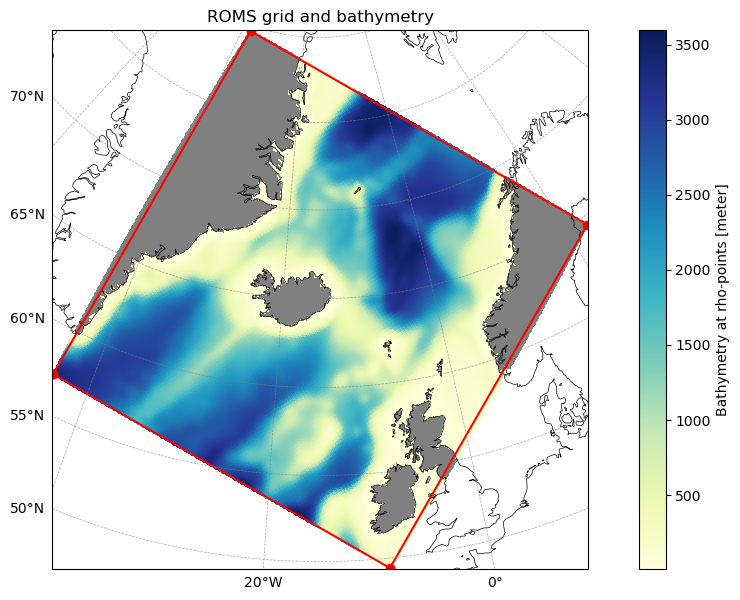

In [18]:
grid.plot()

Next, we specify the start and end times of the underlying ROMS simulation.

In [19]:
simulation_start_time = datetime(2010, 1, 1)
simulation_end_time = datetime(2012, 12, 31)

### Creating the `CDRForcing`

In [20]:
from roms_tools import CDRForcing

Let's first create a `CDRForcing` that consists of all the `VolumeRelease`s that we defined above.

In [21]:
cdr_forcing_with_volume_releases = CDRForcing(
    grid=grid,
    start_time=simulation_start_time,
    end_time=simulation_end_time,
    releases=[
        constant_volume_release_iceland,
        volume_release_greenland,
        volume_release_norway_with_zero_fill,
    ],
)

Similarly, we can create a `CDRForcing` that consists of all the `TracerPerturbation`s that we defined above.

In [22]:
cdr_forcing_with_tracer_perturbations = CDRForcing(
    grid=grid,
    start_time=simulation_start_time,
    end_time=simulation_end_time,
    releases=[
        constant_tracer_perturbation_iceland,
        tracer_perturbation_greenland,
    ],
)

The `.ds` attribute of each `CDRForcing` object holds an xarray `Dataset` with the release information. This dataset can eventually be saved to a NetCDF file, providing the ROMS input file.  

In [23]:
cdr_forcing_with_volume_releases.ds

<xarray.Dataset> Size: 17kB
Dimensions:           (time: 9, ncdr: 3, ntracers: 34)
Coordinates:
  * time              (time) datetime64[ns] 72B 2010-01-01 ... 2012-12-31
    release_name      (ncdr) <U24 288B 'iceland_release' ... 'norway_release_...
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
Dimensions without coordinates: ncdr, ntracers
Data variables:
    cdr_time          (time) float64 72B 3.653e+03 4.032e+03 ... 4.748e+03
    cdr_lon           (ncdr) float64 24B -25.0 -20.0 10.0
    cdr_lat           (ncdr) float64 24B 65.0 70.0 65.0
    cdr_dep           (ncdr) float64 24B 10.0 100.0 50.0
    cdr_hsc           (ncdr) float64 24B 0.0 0.0 0.0
    cdr_vsc           (ncdr) float64 24B 0.0 0.0 0.0
    cdr_volume        (time, ncdr) float64 216B 1e+03 0.0 0.0 ... 1e+03 0.0 0.0
    cdr_tracer        (time, ntracers, ncdr) float64 7kB 20.0 20.0 ... 0.0

The dataset above contains 3 releases, as indicated by the `ncdr` dimension.

In contrast, the next dataset contains only 2 releases, as expected.

In [24]:
cdr_forcing_with_tracer_perturbations.ds

<xarray.Dataset> Size: 15kB
Dimensions:           (time: 9, ncdr: 2, ntracers: 34)
Coordinates:
  * time              (time) datetime64[ns] 72B 2010-01-01 ... 2012-12-31
    release_name      (ncdr) <U17 136B 'iceland_release' 'greenland_release'
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U17 2kB 'degrees Celsius/s' ... 'mmol/s'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
Dimensions without coordinates: ncdr, ntracers
Data variables:
    cdr_time          (time) float64 72B 3.653e+03 4.032e+03 ... 4.748e+03
    cdr_lon           (ncdr) float64 16B -25.0 -20.0
    cdr_lat           (ncdr) float64 16B 65.0 70.0
    cdr_dep           (ncdr) float64 16B 10.0 100.0
    cdr_hsc           (ncdr) float64 16B 1e+05 4e+04
    cdr_vsc           (ncdr) float64 16B 100.0 10.0
    cdr_trcflx        (time, ntracers, ncdr) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0

### Plotting the Release Locations and Distributions

We now continue with visualizing the release locations and distributions. First, we will create a bird's-eye view of the **release location centers**.

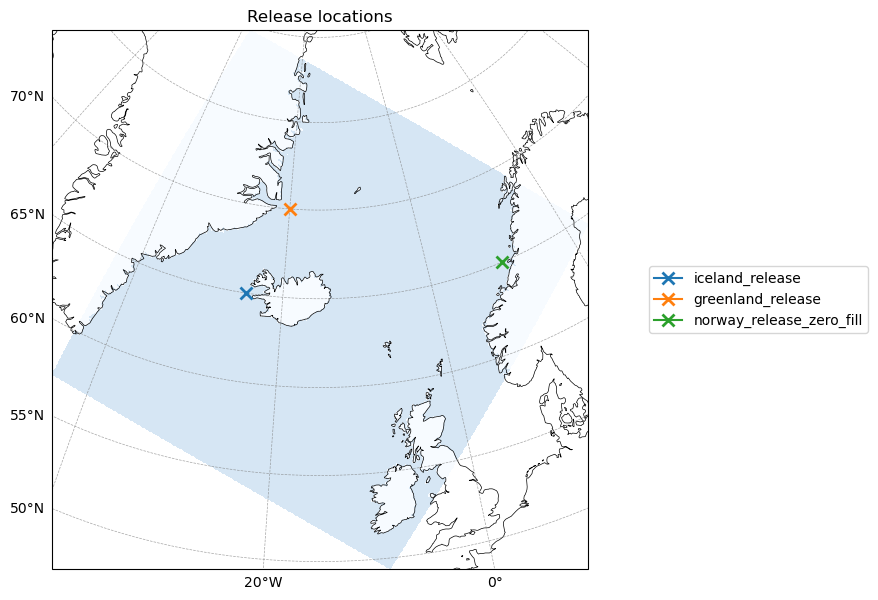

In [25]:
cdr_forcing_with_volume_releases.plot_locations()  # By default, this plots all available releases.

We can also restrict the plot to display only the releases of interest by specifying them in a list via the `release_names` parameter.

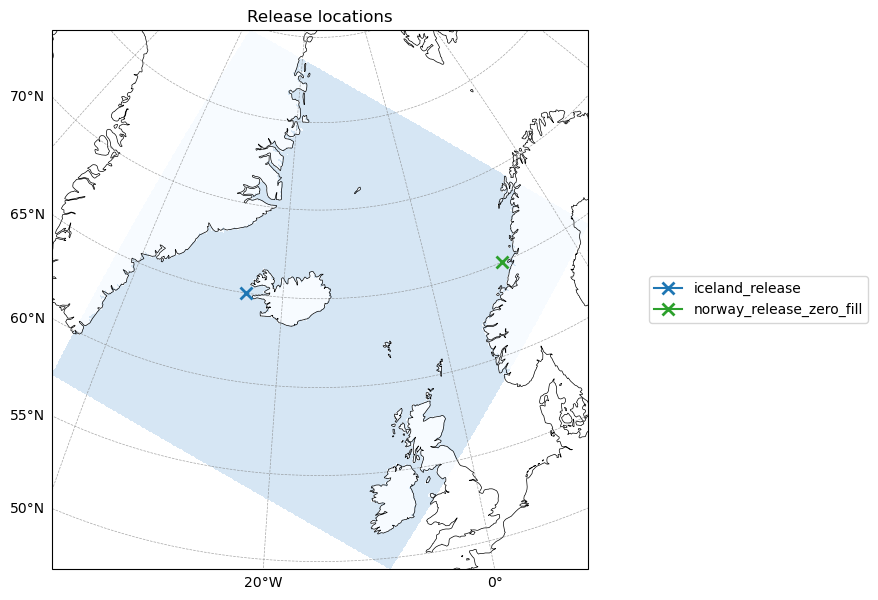

In [26]:
cdr_forcing_with_volume_releases.plot_locations(
    release_names=["iceland_release", "norway_release_zero_fill"]
)

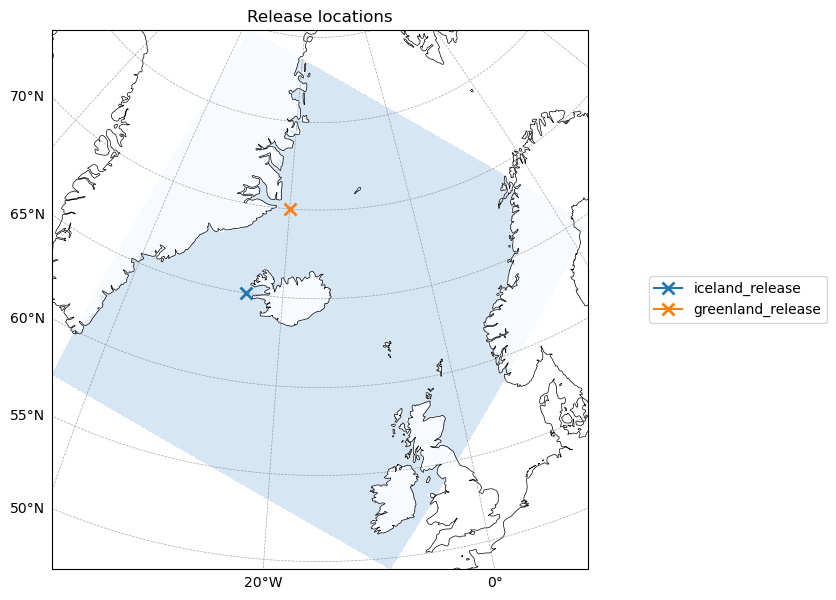

In [27]:
cdr_forcing_with_tracer_perturbations.plot_locations()

Next, we plot the release distributions from a top and side view. Note that we can only plot one release at a time in this view, as the latitude and longitude section to be visualized depends on the specific location of the release itself.

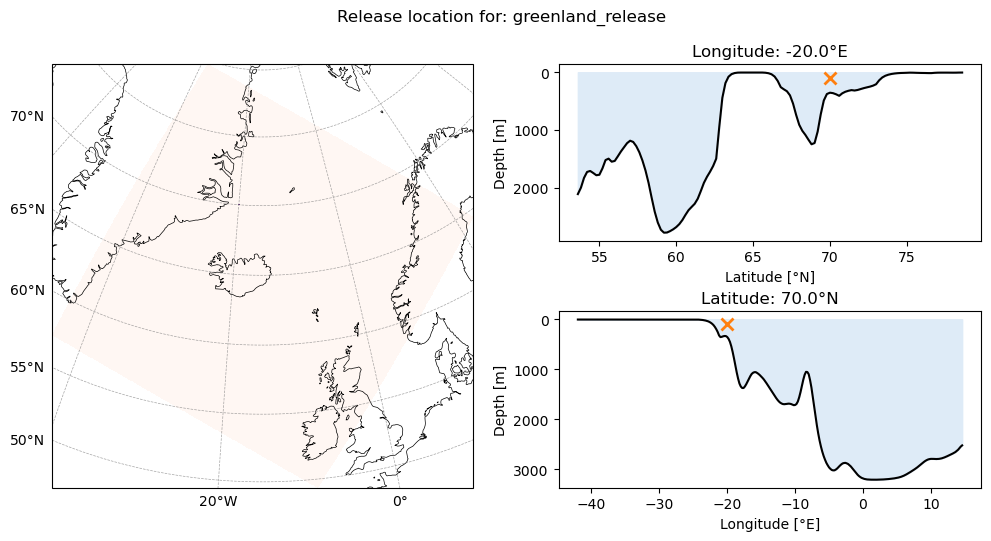

In [28]:
cdr_forcing_with_volume_releases.plot_distribution(release_name="greenland_release")

The `VolumeRelease` we visualized in the plot above is a point source. Next, let's visualize our tracer perturbations, which are released as Gaussian distributions.

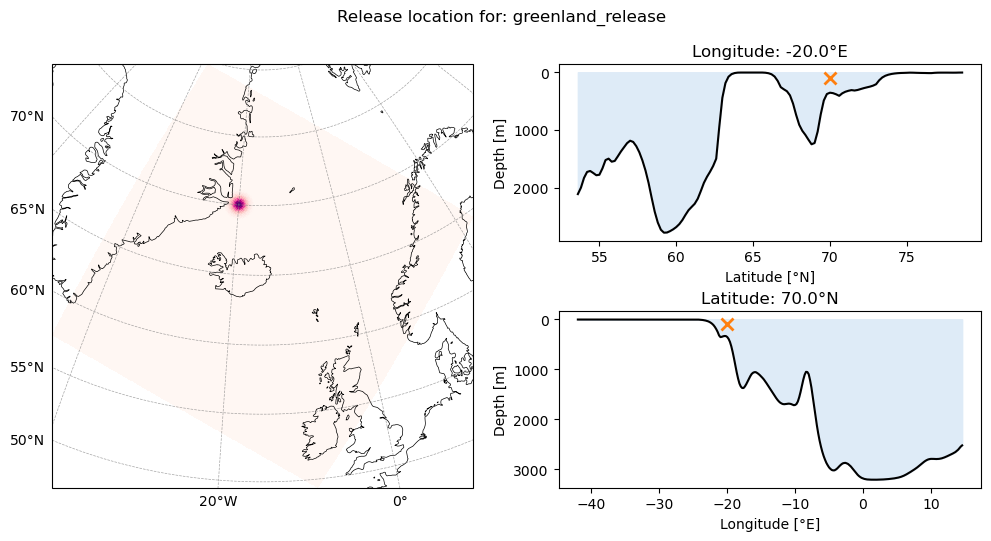

In [29]:
cdr_forcing_with_tracer_perturbations.plot_distribution(
    release_name="greenland_release"
)

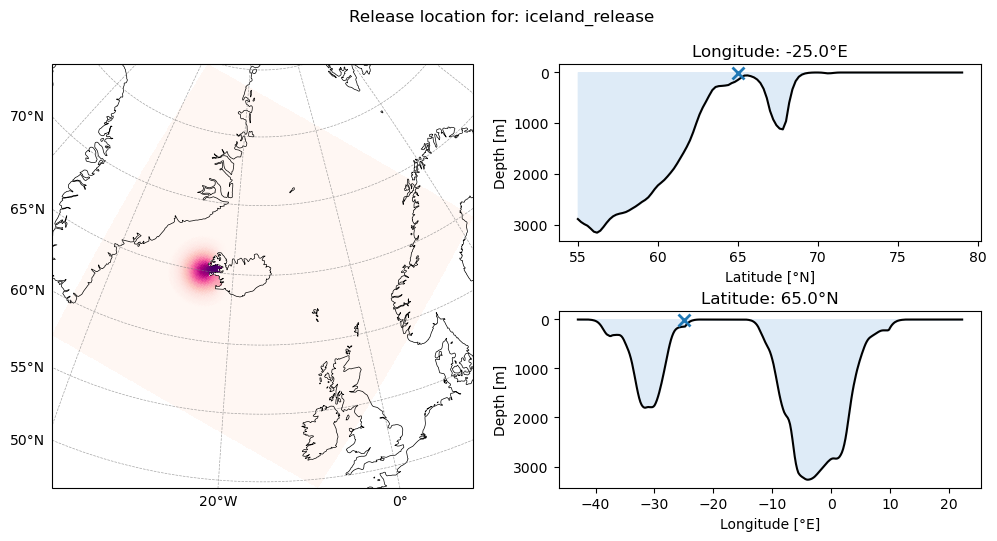

In [30]:
cdr_forcing_with_tracer_perturbations.plot_distribution(release_name="iceland_release")

### Plotting Volume Fluxes and Tracer Concentrations

This section applies only to `CDRForcing` objects that contain releases of type `VolumeRelease`. These releases are associated with both volume fluxes and tracer concentrations, which we will visualize next.

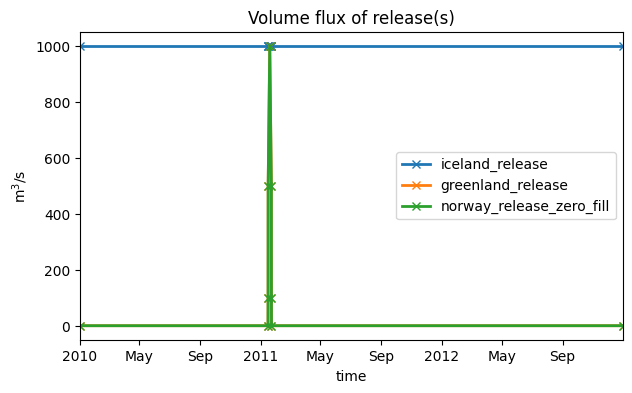

In [28]:
cdr_forcing_with_volume_releases.plot_volume_flux()

You can see that the `iceland_release` applies a constant volume flux throughout the entire simulation period, while the other two releases have time-varying volume fluxes, just as we designed them earlier.

If desired, you can also limit the plot to specific releases using the `release_names` parameter.

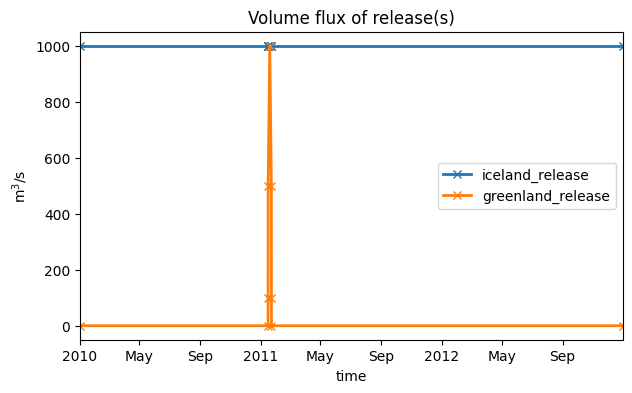

In [29]:
cdr_forcing_with_volume_releases.plot_volume_flux(
    release_names=["iceland_release", "greenland_release"]
)

We can also zoom into the specific time window where the `greenland_release` occurs to better visualize the time-varying behavior of the volume flux.

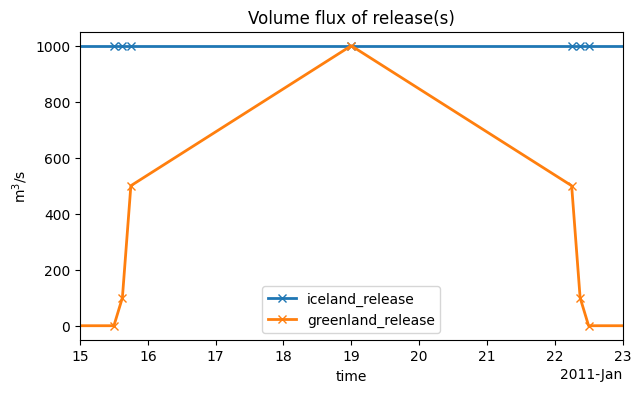

In [30]:
cdr_forcing_with_volume_releases.plot_volume_flux(
    release_names=["iceland_release", "greenland_release"],
    start=datetime(2011, 1, 15),
    end=datetime(2011, 1, 23),
)

Next, we plot the alkalinity concentration.

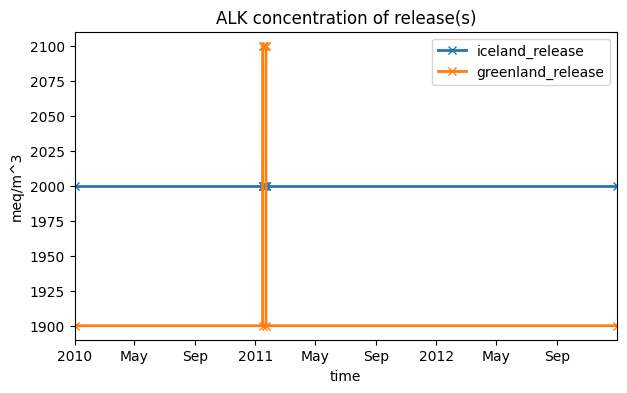

In [31]:
cdr_forcing_with_volume_releases.plot_tracer_concentration(
    tracer_name="ALK", release_names=["iceland_release", "greenland_release"]
)

Again, the `iceland_release` uses an alkalinity concentration that is constant in time, while the `greenland_release` has a time-varying alkalinity concentration.

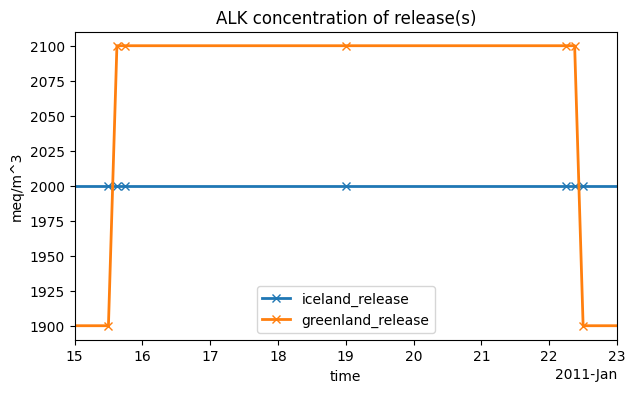

In [32]:
cdr_forcing_with_volume_releases.plot_tracer_concentration(
    tracer_name="ALK",
    release_names=["iceland_release", "greenland_release"],
    start=datetime(2011, 1, 15),
    end=datetime(2011, 1, 23),
)

Finally, we plot the DIC concentration to visualize the effect of the default fill versus the zero fill.

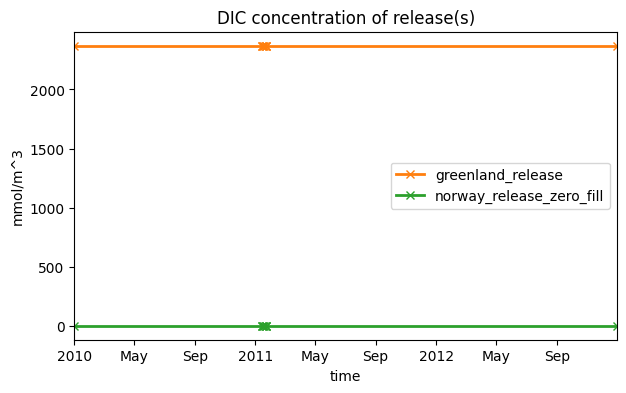

In [33]:
cdr_forcing_with_volume_releases.plot_tracer_concentration(
    tracer_name="DIC", release_names=["greenland_release", "norway_release_zero_fill"]
)

### Plotting Tracer Fluxes

This section applies only to `CDRForcing` objects that contain releases of type `TracerPerturbation`. These releases are associated with tracer fluxes, which we will visualize next. The `plot_tracer_flux` method works similarly as the `plot_volume_flux` and `plot_tracer_concentration` methods above.

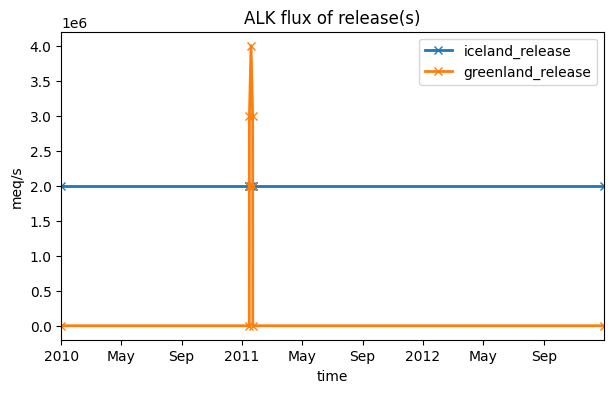

In [34]:
cdr_forcing_with_tracer_perturbations.plot_tracer_flux(tracer_name="ALK")

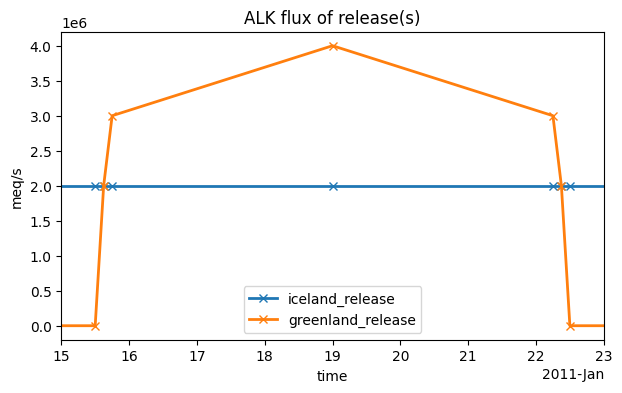

In [35]:
cdr_forcing_with_tracer_perturbations.plot_tracer_flux(
    tracer_name="ALK", start=datetime(2011, 1, 15), end=datetime(2011, 1, 23)
)

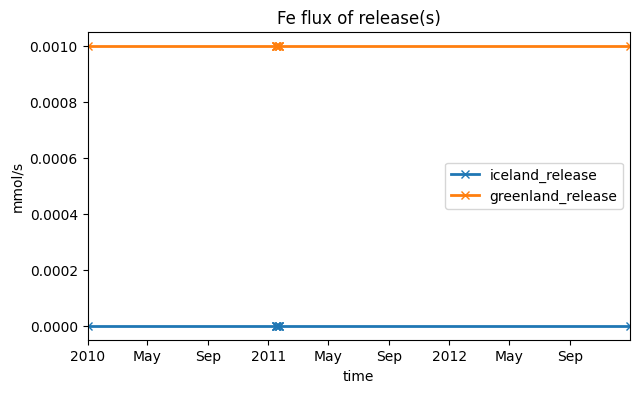

In [36]:
cdr_forcing_with_tracer_perturbations.plot_tracer_flux(tracer_name="Fe")

### Automatic Extrapolation to Simulation Endpoints

<div class="alert alert-info">

Important

ROMS requires volume fluxes and tracer concentrations for the entire simulation period. The values are linearly interpolated between the provided time points. If the user does not specify the simulation's start and end points in their time series, `ROMS-Tools` will apply the following defaults:

* Volume and tracer fluxes are set to 0 at both the start and end times.
* Tracer concentrations at the start and end times are set to the values from the closest available time stamps.

</div>

Let’s examine how these rules play out in practice by revisiting one of our earlier `VolumeRelease` examples: `volume_release_greenland`.
This release was defined with the following times, volume fluxes, and alkalinity concentrations (where the endpoints have been filled in when we built `cdr_forcing_with_volume_releases`).

In [37]:
volume_release_greenland.times

[datetime.datetime(2010, 1, 1, 0, 0),
 datetime.datetime(2011, 1, 15, 12, 0),
 datetime.datetime(2011, 1, 15, 15, 0),
 datetime.datetime(2011, 1, 15, 18, 0),
 datetime.datetime(2011, 1, 19, 0, 0),
 datetime.datetime(2011, 1, 22, 6, 0),
 datetime.datetime(2011, 1, 22, 9, 0),
 datetime.datetime(2011, 1, 22, 12, 0),
 datetime.datetime(2012, 12, 31, 0, 0)]

In [38]:
volume_release_greenland.volume_fluxes.values

[0.0, 0.0, 100.0, 500.0, 1000.0, 500.0, 100.0, 0.0, 0.0]

In [39]:
volume_release_greenland.tracer_concentrations["ALK"].values

[1900.0, 1900.0, 2100.0, 2100.0, 2100.0, 2100.0, 2100.0, 1900.0, 1900.0]

In the next example, we define a very similar release as before, but we omit the first two and the last two timestamps from the time series.

In [40]:
times = volume_release_greenland.times[2:-2]
times

[datetime.datetime(2011, 1, 15, 15, 0),
 datetime.datetime(2011, 1, 15, 18, 0),
 datetime.datetime(2011, 1, 19, 0, 0),
 datetime.datetime(2011, 1, 22, 6, 0),
 datetime.datetime(2011, 1, 22, 9, 0)]

In [41]:
volume_fluxes = volume_release_greenland.volume_fluxes.values[2:-2]
volume_fluxes

[100.0, 500.0, 1000.0, 500.0, 100.0]

In [42]:
alk_concentration = volume_release_greenland.tracer_concentrations["ALK"].values[2:-2]
alk_concentration

[2100.0, 2100.0, 2100.0, 2100.0, 2100.0]

In [43]:
volume_release_greenland_truncated = VolumeRelease(
    name="greenland_release_cut_short",
    lat=volume_release_greenland.lat,
    lon=volume_release_greenland.lon,
    depth=volume_release_greenland.depth,
    times=times,
    volume_fluxes=volume_fluxes,
    tracer_concentrations={"ALK": alk_concentration},
)

In [44]:
cdr_forcing = CDRForcing(
    grid=grid,
    start_time=simulation_start_time,
    end_time=simulation_end_time,
    releases=[volume_release_greenland, volume_release_greenland_truncated],
)

Let's now compare the time series of volume flux and alkalinity concentration for the two releases.

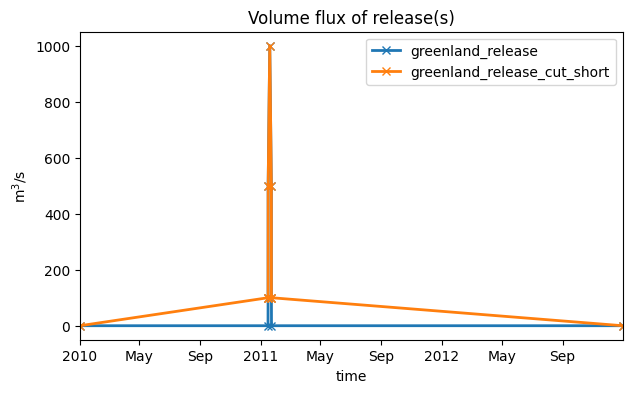

In [45]:
cdr_forcing.plot_volume_flux()

To re-iterate, the above plot shows the effect of choosing:

- `volume_fluxes = [0.0, 100.0, 500.0, 1000.0, 500.0, 100.0, 0.0]` (blue line) vs.
- `volume_fluxes = [100.0, 500.0, 1000.0, 500.0, 100.0]` (orange line)

The first choice explicitly defines when to shut off the volume flux.  
The second choice does not define this, so `ROMS-Tools` assumes the flux is only shut off at the simulation endpoints and linearly interpolates in between.

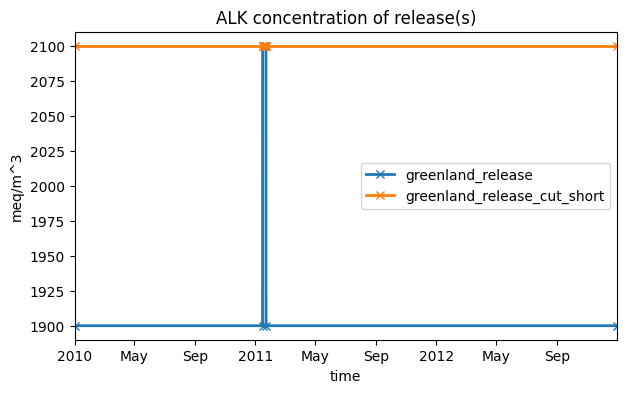

In [46]:
cdr_forcing.plot_tracer_concentration(tracer_name="ALK")

To re-iterate, the above plot shows the effect of choosing:

- `tracer_concentrations["ALK"] = [1900.0, 2100.0, 2100.0, 2100.0, 2100.0, 2100.0, 1900.0]` (blue line) vs.
- `tracer_concentrations["ALK"] = [2100.0, 2100.0, 2100.0, 2100.0, 2100.0]` (orange line)

In both cases, `ROMS-Tools` extrapolates the endpoints of the provided time series to the simulation endpoints.

### Saving as NetCDF or YAML File

We can now save our CDR forcing data as a NetCDF file using the `.save` method. This file will include the dataset stored in `.ds`. The resulting NetCDF file can then be used as input for ROMS simulations. 

In this example, we focus on the CDR forcing built from `VolumeRelease` objects, but the same saving procedure applies to CDR forcing created from `TracerPerturbation` objects.

In [47]:
filepath = "/pscratch/sd/n/nloose/forcing/my_cdr_forcing.nc"

In [48]:
cdr_forcing_with_volume_releases.save(filepath=filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_cdr_forcing.nc


[PosixPath('/pscratch/sd/n/nloose/forcing/my_cdr_forcing.nc')]

We can also export the CDR forcing parameters and their associated release information to a YAML file.

In [49]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_cdr_forcing.yaml"

In [50]:
cdr_forcing_with_volume_releases.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [51]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 2.6.3.dev18+gdb32644
---
Grid:
  nx: 250
  ny: 250
  size_x: 2500
  size_y: 2500
  center_lon: -15
  center_lat: 65
  rot: -30
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
CDRForcing:
  start_time: '2010-01-01T00:00:00'
  end_time: '2012-12-31T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  releases:
  - name: iceland_release
    lat: 65.0
    lon: -25.0
    depth: 10.0
    hsc: 0.0
    vsc: 0.0
    times:
    - 2010-01-01 00:00:00
    - 2012-12-31 00:00:00
    release_type: volume
    fill_values: auto
    volume_fluxes:
    - 1000.0
    - 1000.0
    tracer_concentrations:
      temp:
      - 20.0
      - 20.0
      salt:
      - 1.0
      - 1.0
      ALK:
      - 2000.0
      - 2000.0
      PO4:
      - 2.7
      - 2.7
      NO3:
      - 24.2
      - 24.2
      SiO3:
      - 13.2
      - 13.2
      NH4:
      - 2.2
      - 2.

### Creating CDR forcing from an existing YAML file

Once we have the YAML file containing the CDR forcing parameters and release information, we can use it to recreate the exact same CDR forcing.

In [52]:
the_same_cdr_forcing_with_volume_releases = CDRForcing.from_yaml(yaml_filepath)

The dataset contained in the `.ds` contains the same three releases as before.

In [53]:
the_same_cdr_forcing_with_volume_releases.ds

<xarray.Dataset> Size: 17kB
Dimensions:           (time: 9, ncdr: 3, ntracers: 34)
Coordinates:
  * time              (time) datetime64[ns] 72B 2010-01-01 ... 2012-12-31
    release_name      (ncdr) <U24 288B 'iceland_release' ... 'norway_release_...
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
Dimensions without coordinates: ncdr, ntracers
Data variables:
    cdr_time          (time) float64 72B 3.653e+03 4.032e+03 ... 4.748e+03
    cdr_lon           (ncdr) float64 24B -25.0 -20.0 10.0
    cdr_lat           (ncdr) float64 24B 65.0 70.0 65.0
    cdr_dep           (ncdr) float64 24B 10.0 100.0 50.0
    cdr_hsc           (ncdr) float64 24B 0.0 0.0 0.0
    cdr_vsc           (ncdr) float64 24B 0.0 0.0 0.0
    cdr_volume        (time, ncdr) float64 216B 1e+03 0.0 0.0 ... 1e+03 0.0 0.0
    cdr_tracer        (time, ntracers, ncdr) float64 7kB 20.0 20.0 ... 0.0